# generate_obs_hte_binary_26()



The `generate_obs_hte_binary_26()` function provides a richer observational dataset with **binary outcomes**, nonlinear confounding, and heterogeneous treatment effects. It uses 11 confounders with behavior-driven derived features and a moderate target treatment rate.


#### 1. Confounders ($X$)
The dataset contains 11 confounders $X = (X_1, \dots, X_{11})^T$:
- $X_1$: `tenure_months`
- $X_2$: `avg_sessions_week`
- $X_3$: `spend_last_month`
- $X_4$: `age_years`
- $X_5$: `prior_purchases_12m`
- $X_6$: `support_tickets_90d`
- $X_7$: `premium_user`
- $X_8$: `mobile_user`
- $X_9$: `weekend_user`
- $X_{10}$: `email_opt_in`
- $X_{11}$: `referred_user`

**Base Features Sampling:**
The base features $(X_1, X_2, X_3, X_4, X_9)$ are sampled using a **Gaussian Copula** with correlation matrix:

$$\Sigma = \begin{pmatrix}
1.00 & 0.25 & 0.20 & 0.25 & 0.05 \\
0.25 & 1.00 & 0.45 & -0.20 & 0.30 \\
0.20 & 0.45 & 1.00 & -0.10 & 0.20 \\
0.25 & -0.20 & -0.10 & 1.00 & -0.15 \\
0.05 & 0.30 & 0.20 & -0.15 & 1.00
\end{pmatrix}$$

**Derived Features:**
The remaining confounders are generated from behavior-linked models:
- **Premium User ($X_7$):** $\text{logit}(P(X_7=1)) = -4.6 + 0.70 \ln(1+X_2) + 0.45 \ln(1+X_3) + 0.012 X_1 + 0.20 X_9$
- **Mobile User ($X_8$):** $\text{logit}(P(X_8=1)) = 1.4 - 0.03(X_4 - 35) + 0.25 X_9 + 0.22 \ln(1+X_2)$
- **Referred User ($X_{11}$):** $\text{logit}(P(X_{11}=1)) = -1.3 - 0.02(X_1 - 12) + 0.42 X_8 + 0.25 X_9$
- **Email Opt-in ($X_{10}$):** $\text{logit}(P(X_{10}=1)) = -0.6 + 0.50 X_8 + 0.35 X_7 + 0.20 X_9 + 0.12 \ln(1+X_2)$
- **Prior Purchases ($X_5$):** $X_5 \sim \text{Poisson}(\lambda = \text{clip}(0.9 + 0.52 \ln(1+X_2) + 0.40 \ln(1+X_3) + 0.24 X_7 + 0.12 X_{10}, 0.05, 25.0))$
- **Support Tickets ($X_6$):** $X_6 \sim \text{Poisson}(\lambda = \text{clip}(0.55 + 0.22 \ln(1+X_2) + 0.32(1-X_7) + 0.18(1-X_{10}) + 0.12 \tanh(\frac{X_4 - 45}{12}), 0.05, 10.0))$


#### 2. Treatment Assignment ($D$)
The treatment $D \in \{0, 1\}$ is assigned with a target rate of **15%**:
$$P(D=1|X) = \sigma\left( \alpha_d + \text{bound}(f_d(X), 2.0) \right)$$
where $f_d(X) = \sum_{j=1}^{11} \beta_{d,j} X_j + g_d(X)$ and
$$g_d(X) = 0.85\tanh\left(\ln\frac{1+X_3}{61}\right) + 0.24\ln\frac{1+X_2}{6}\tanh\left(\frac{X_1}{24}-1\right) + 0.30X_7(X_9-0.5) + 0.22X_{10}\tanh\left(\ln\frac{1+X_2}{4}\right) + 0.25X_{11}\left(1-\tanh\frac{X_1}{36}\right) + 0.14\tanh\left(\ln\frac{1+X_6}{2.5}\right) - 0.10\tanh\left(\frac{X_4-45}{12}\right).$$


#### 3. Heterogeneous Treatment Effect ($\tau(X)$)
For this binary-outcome scenario, treatment effect is on the **log-odds** scale:
$$\tau(X) = 0.30 + 0.40\tanh\left(\ln\frac{1+X_2}{6}\right) + 0.45X_7 + 0.12X_8 + 0.10X_{10} + 0.12X_{11} - 0.32\tanh\frac{X_1}{48} - 0.18\tanh\frac{X_4-40}{15} + 0.10X_9\tanh\left(\ln\frac{1+X_3}{61}\right) - 0.12\tanh\left(\ln\frac{1+X_6}{2.5}\right).$$
The treatment effect is clipped to $[-0.35, 1.4]$.


#### 4. Outcome Model ($Y$)
The outcome is **binary** with logistic link:
$$P(Y=1\mid X,D) = \sigma\left(\alpha_y + \sum_{j=1}^{11}\beta_{y,j}X_j + g_y(X) + D\cdot\tau(X)\right),$$
with $\alpha_y = -1.7$.

The nonlinear baseline component is:
$$g_y(X) = 1.1\tanh\frac{X_1}{24} + 0.50\left(\ln\frac{1+X_2}{6}\right)^2 + 0.22\ln\frac{1+X_3}{61}\ln\frac{1+X_2}{6} - 0.35\ln(1+X_6) + 0.18\ln(1+X_5)\tanh\frac{X_1}{18} + 0.22X_8\ln\frac{1+X_2}{6} + 0.20X_7(X_9-0.5) + 0.18X_{10}\tanh\left(\frac{1}{2}\ln\frac{1+X_3}{61}\right) + 0.14X_{11}\tanh\left(\frac{X_1}{12}-1\right) - 0.20\tanh\frac{X_4-40}{15}.$$

Oracle CATE is reported on the natural scale as a **risk difference** (`g1 - g0`).


In [1]:
from causalis.scenarios.unconfoundedness.dgp import generate_obs_hte_binary_26

data = generate_obs_hte_binary_26(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,age_years,prior_purchases_12m,support_tickets_90d,premium_user,mobile_user,weekend_user,email_opt_in,referred_user,m,m_obs,tau_link,g0,g1,cate
0,0.0,0.0,28.814654,1.0,78.459423,50.392490,4.0,2.0,0.0,1.0,1.0,1.0,0.0,0.136804,0.136804,-0.075690,0.259586,0.245305,-0.014281
1,1.0,1.0,10.987367,3.0,38.652698,31.652666,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.157599,0.157599,0.781429,0.592325,0.760425,0.168101
2,0.0,1.0,40.678212,9.0,98.950760,48.634055,4.0,5.0,0.0,1.0,0.0,0.0,0.0,0.165401,0.165401,0.209518,0.043862,0.053538,0.009676
3,0.0,1.0,14.331764,5.0,27.386588,42.502641,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.158897,0.158897,0.630457,0.148391,0.246602,0.098211
4,0.0,1.0,21.480304,2.0,119.753960,35.311382,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.169943,0.169943,0.346384,0.527043,0.611748,0.084704


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")


Ground truth ATE is 0.08155183943650529
Ground truth ATTE is 0.10123794590017934


In [3]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months',
                                     'avg_sessions_week',
                                     'spend_last_month',
                                     'age_years',
                                     'prior_purchases_12m',
                                     'support_tickets_90d',
                                     'premium_user',
                                     'mobile_user',
                                     'weekend_user',
                                     'email_opt_in',
                                     'referred_user'])
causaldata


CausalData(df=(100000, 13), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'age_years', 'prior_purchases_12m', 'support_tickets_90d', 'premium_user', 'mobile_user', 'weekend_user', 'email_opt_in', 'referred_user'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,85067,0.437726,0.496110,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1.0,14933,0.579388,0.493674,0.0,0.0,0.0,1.0,1.0,1.0,1.0


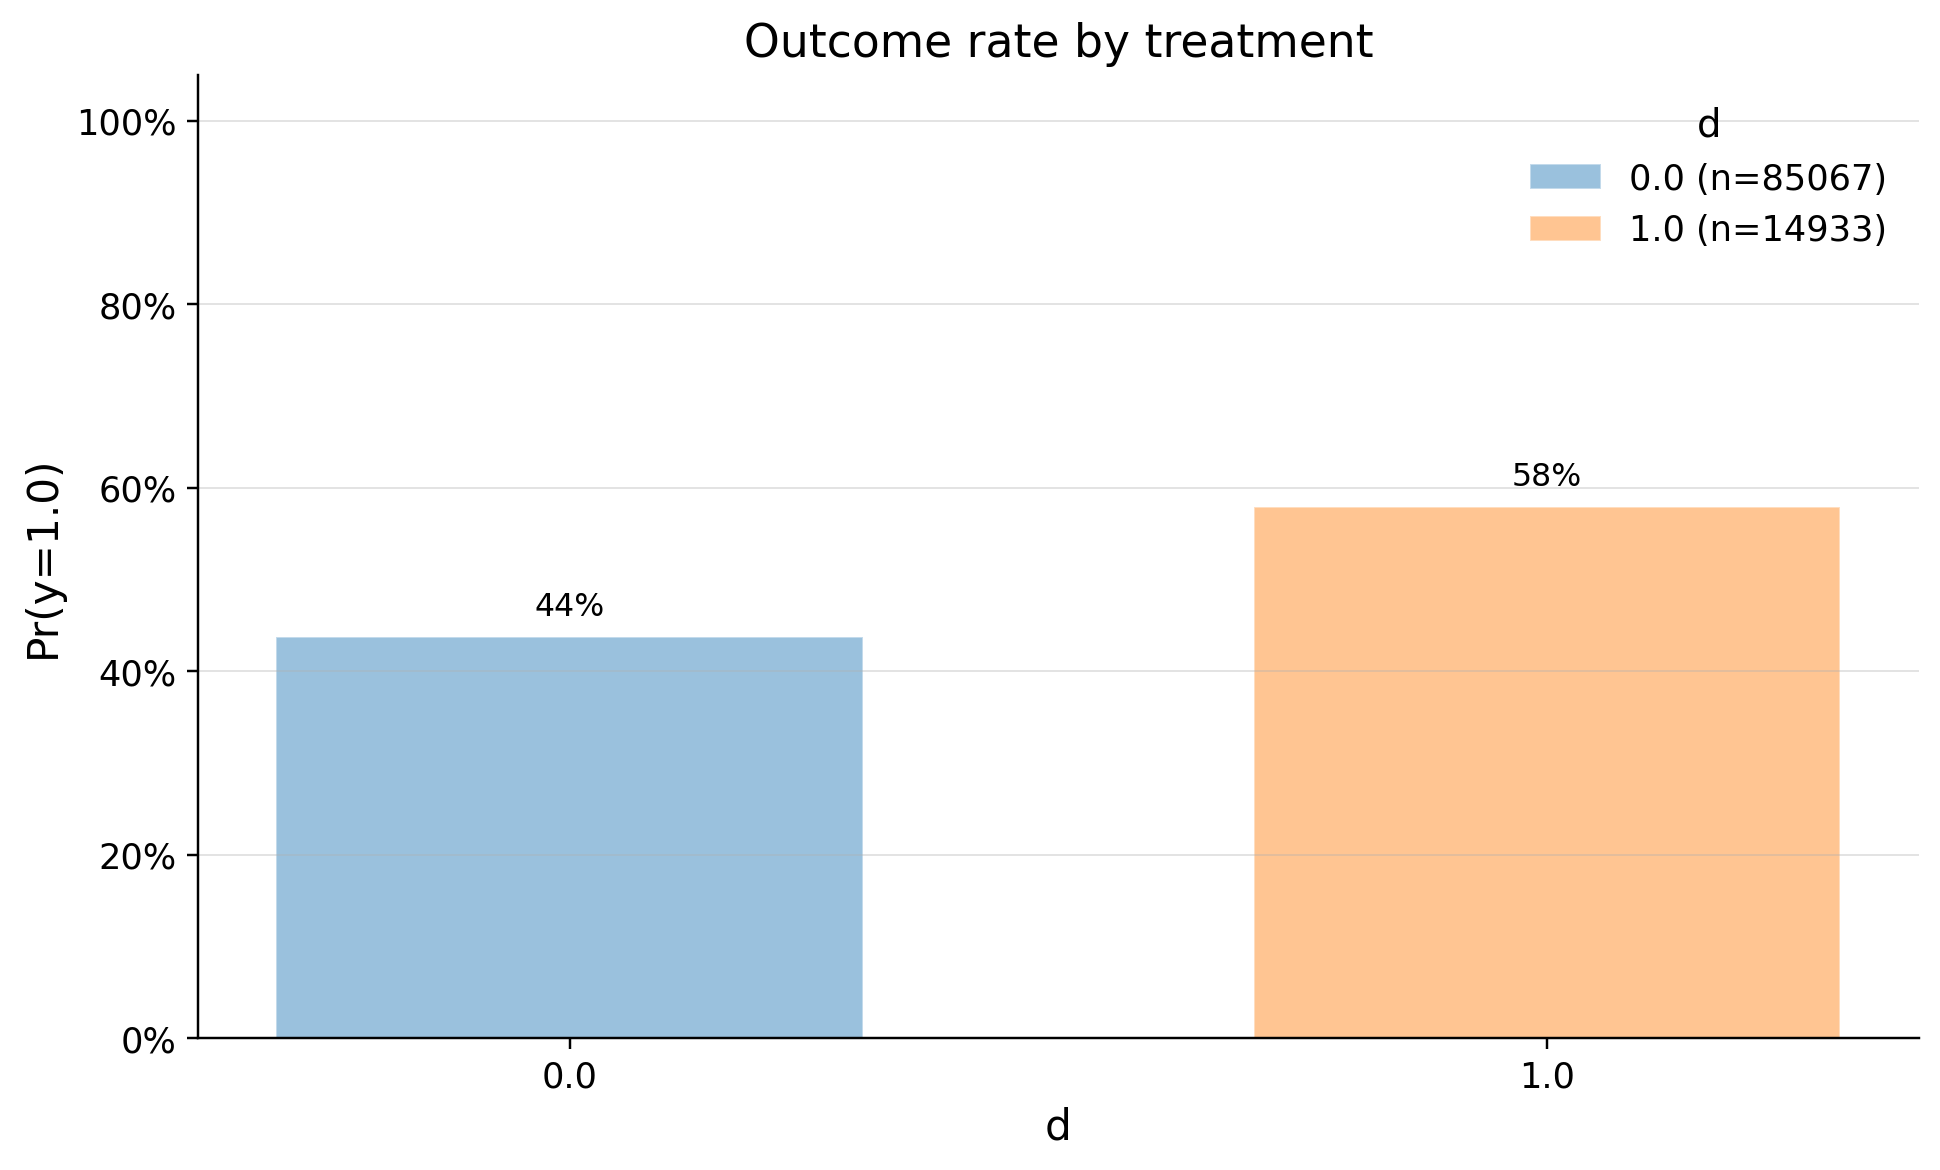

In [5]:
from causalis.shared import outcome_plot_dist, outcome_plot_boxplot
outcome_plot_dist(causaldata)

In [8]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,spend_last_month,83.486832,114.093736,30.606905,0.336140,0.00000
1,premium_user,0.237378,0.371325,0.133948,0.294234,0.00000
2,avg_sessions_week,4.823410,6.005089,1.181680,0.271347,0.00000
3,prior_purchases_12m,3.420633,3.802317,0.381684,0.190848,0.00000
4,referred_user,0.243197,0.310052,0.066855,0.149870,0.00000
5,age_years,36.594622,35.069304,1.525318,-0.136350,0.00000
6,email_opt_in,0.542490,0.593652,0.051162,0.103421,0.00000
7,mobile_user,0.851270,0.882676,0.031406,0.092575,0.00000
8,support_tickets_90d,1.141982,1.243555,0.101572,0.091742,0.00000
9,tenure_months,28.338387,29.848652,1.510265,0.081531,0.00000
